Initial shape: (9380, 22)

Missing values per column:
Season               0
MatchDate            0
HomeTeam             0
AwayTeam             0
FullTimeHomeGoals    0
FullTimeAwayGoals    0
FullTimeResult       0
HalfTimeHomeGoals    0
HalfTimeAwayGoals    0
HalfTimeResult       0
HomeShots            0
AwayShots            0
HomeShotsOnTarget    0
AwayShotsOnTarget    0
HomeCorners          0
AwayCorners          0
HomeFouls            0
AwayFouls            0
HomeYellowCards      0
AwayYellowCards      0
HomeRedCards         0
AwayRedCards         0
dtype: int64

Shape after cleaning: (9380, 22)


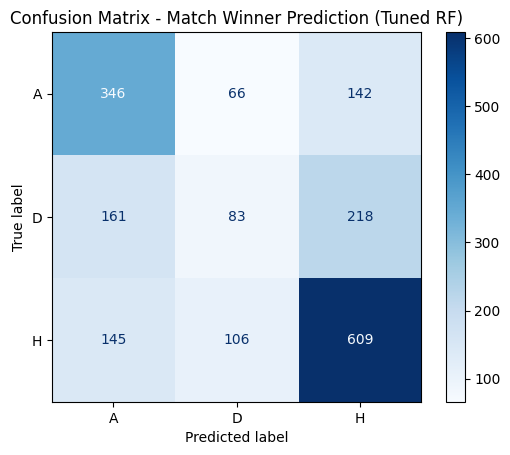

Model Accuracy: 0.55

Classification Report:
              precision    recall  f1-score   support

           A       0.53      0.62      0.57       554
           D       0.33      0.18      0.23       462
           H       0.63      0.71      0.67       860

    accuracy                           0.55      1876
   macro avg       0.49      0.50      0.49      1876
weighted avg       0.52      0.55      0.53      1876


Feature Importance Ranking:
1. HomeShotsOnTarget: 0.1320
2. AwayShotsOnTarget: 0.1209
3. HomeTeam: 0.0961
4. AwayTeam: 0.0960
5. AwayShots: 0.0831
6. HomeShots: 0.0831
7. AwayFouls: 0.0758
8. HomeFouls: 0.0728
9. HomeCorners: 0.0705
10. AwayCorners: 0.0657
11. HomeYellowCards: 0.0462
12. AwayYellowCards: 0.0432
13. HomeRedCards: 0.0078
14. AwayRedCards: 0.0071


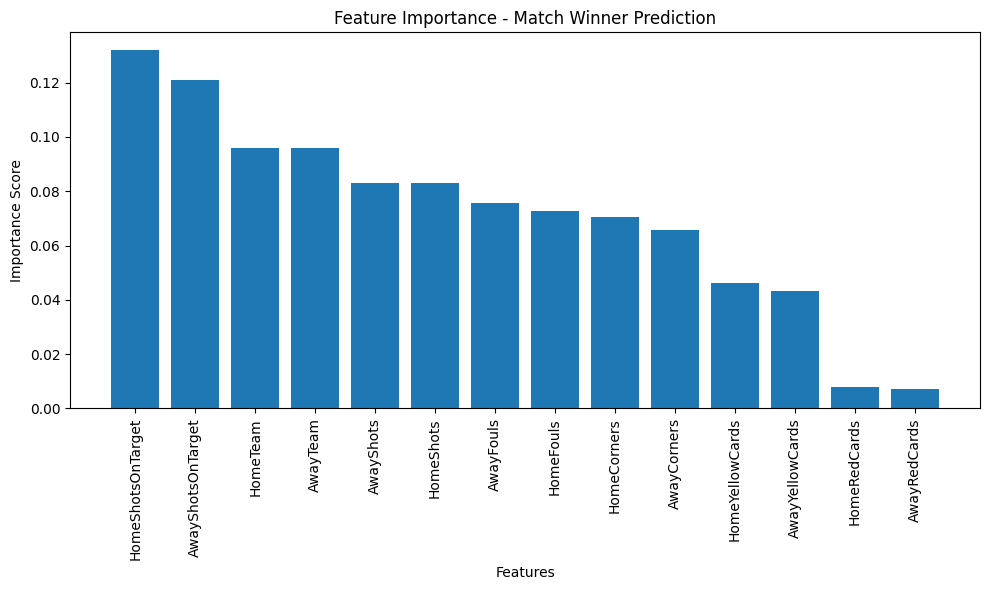

In [13]:
# ===============================
# Match Winner Prediction + Feature Importance (with Hyperparameters)
# ===============================

# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)

# 1. Load dataset
file_path = "/content/every_match.csv"   # <-- update if needed
df = pd.read_csv(file_path)

# --- Data Cleaning ---
print("Initial shape:", df.shape)

# Check nulls
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop nulls
df = df.dropna()

# Remove duplicates
df = df.drop_duplicates()

print("\nShape after cleaning:", df.shape)

# 2. Target column
y = df["FullTimeResult"]

# 3. Drop ONLY the real leakage columns
leakage_cols = [
    "FullTimeHomeGoals", "FullTimeAwayGoals",
    "HalfTimeHomeGoals", "HalfTimeAwayGoals", "HalfTimeResult"
]
X = df.drop(columns=["Season", "MatchDate", "FullTimeResult"] + leakage_cols)

# 4. Encode categorical features (teams)
for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Train model with hyperparameters
clf = RandomForestClassifier(
    n_estimators=300,        # number of trees (default=100, higher = better)
    max_depth=20,           # prevent overly deep trees
    min_samples_split=5,    # minimum samples required to split a node
    min_samples_leaf=4,     # minimum samples at a leaf node
    max_features="sqrt",    # number of features per split
    bootstrap=True,         # bootstrap sampling
    random_state=42,
    class_weight="balanced" # handle class imbalance
)
clf.fit(X_train, y_train)

# 7. Predictions
y_pred = clf.predict(X_test)

# 8. Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Match Winner Prediction (Tuned RF)")
plt.show()

# 9. Accuracy & Report
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 10. Feature Importance
importances = clf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Print ranking
print("\nFeature Importance Ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot graph
plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.title("Feature Importance - Match Winner Prediction")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()
